# Machine Learning in Python - Project 1

*Pablo Denis González de Vega, Mary O'Brien, Dexter Black, Nikita Jegorovs*

## Setup

*Install any packages here and load data*

In [24]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import f_regression, SelectKBest

In [2]:
#The smaller dataset:
d = pd.read_csv("easyshare.csv")

#The full dataset:
d_complex = pd.read_csv("easyshare_all.csv")

# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. European Union, Governments, Health Institutes and/or Charities on dementia and ageing). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

In the code block below we clean the data in the d data frame. Firstly, we drop any rows that have a missing value in the *cogscore* column, of which there were 976. We do this because this is precisely what we are trying to predict, and therefore if we don't know what that person's *cogscore* is then the rest of their information is useless because we don't know how it relates to *cogscore*. In addition, we drop 8 columns. Their names and the justification for dropping each is provided below:
- **int_year**: This column is dropped because the year in which each person was interviewed is irrelevant when it comes to their cognitive abilities. What matters is their age at that year, *not* the year itself.
- **wave**: Similarly, the wave in which each person was interviewed is not related to their *cogscore*. Presumably a person's *cogscore* may worsen with each successive wave, but this is because the person is getting older, not because they were interviewed at any given wave.
- **citizenship**: We dropped *citizenship* because while a person's current country of residence may serve as a proxy for quality of life and access to healthcare, the person's actual citizenship is irrelevant.
- **birth_country**: For the same reason as above *birth_country* was dropped.
- **ch001_**: 
- **bmi2**: There are two BMI-related variables: *bmi* and *bmi2*. The former is a numerical variable with the actual BMI of the person; the latter is a categorical variable in which the person's BMI was assigned to one of 4 categories. We chose to keep the former because it contains considerably more information than *bmi2*, which only has 4 categories.
- **country**: We dropped this column because another country identifier (*country_mod*) also exists, and *country_mod* uses the same identifier for countries as other columns involving countries/nationalities (the ISO code), whereas *country* is the only column to use the identifiers it uses. 
- **eduyears_mod**:

In [3]:
#   Define function for transforming boolean variable to desired format
def transform_bool(x):
    if x != np.nan:
        if x == 5:
            return 0
        elif x == 1:
            return 1
  
# Define a list of binary columns      
binary_list = ['smoking', 'ever_smoked', 'sp008_']

# Convert boolean columns to required format
for i in binary_list:
    d[i] = d[i].apply(lambda x: transform_bool(x))

# Drop rows with missing 'cogscore'
d_cleaned = d.dropna(subset=['cogscore'])

# Drop unnecessary columns 
d_cleaned = d_cleaned.drop(['int_year', 'wave', 'citizenship', 'birth_country', 'ch001_', 'bmi2', 'country', 'eduyears_mod'], axis=1)

As it stands, the `br010_mod` column in our d_cleaned data frame only captures the person's drinking patterns within the last 3 or 6 months, depending on the wave. For those who were interviewed multiple times we may have access to their drinking patterns for several waves in the larger easyshare_all.csv file. Having all of this information could provide a more truthful representation of people's true rate of alcohol consumption, since it tells us how much alcohol they consumed at several points in their lives, as opposed to just at one point, which is the information contained in the easyshare.csv file. 

Therefore, we compute the average `br010_mod` value across all waves for each person, and store it in a new column called `alcohol`. If at any point the person did not answer when asked about their drinking patterns (represented by an `Nan` in the `br010_mod` column) then we set the value of `alcohol` to also be `NaN`. Finally, we merge this with our `d_cleaned` data frame.

In [4]:
# Create a new column 'alcohol' with the mean for each patient across all waves
d_complex['alcohol'] = d_complex.groupby('mergeid')['br010_mod'].transform(lambda x: np.mean(x) if (x >= 0).all() else np.mean(np.where(x >= 0, x, np.nan)))

# Select only the mergeid column (for merging) and the alcohol colun (because we're interested only in that column)
d_complex_for_merging = d_complex[['mergeid', 'alcohol']]

# Merge the simplified alcohol database with our cleaned dataframe.
d_cleaned = d_cleaned.merge(d_complex_for_merging, on='mergeid', how='inner')

# Remove any duplicated that may appear in the process.
d_cleaned = d_cleaned.drop_duplicates()

Text(0.5, 1.0, 'Average Cognitive Score Across Ages')

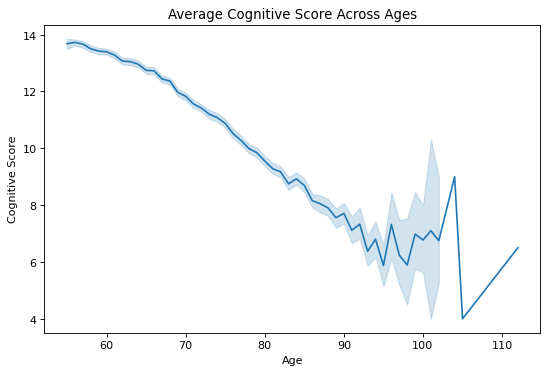

In [5]:
# Age is given to many decimal places so in the code block below we round it to the nearest whole number so we can aggregate.
sns.lineplot(d_cleaned, x = d_cleaned['age'].round(), y = 'cogscore', estimator = 'mean')

plt.xlabel('Age')
plt.ylabel('Cognitive Score')
plt.title('Average Cognitive Score Across Ages')

<Axes: >

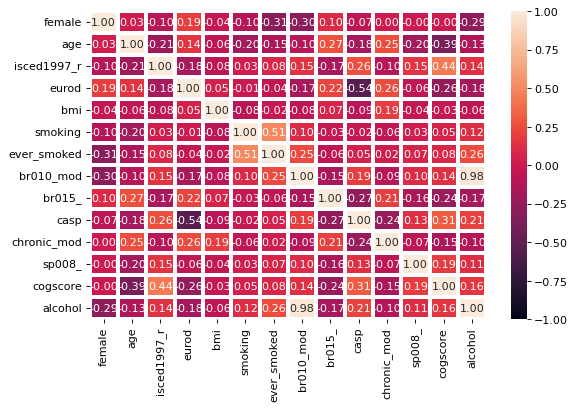

In [6]:
#Numeric Variables for heatmap:
d_cleaned_numeric = d_cleaned.drop(columns = ['mergeid', 'country_mod'])
sns.heatmap(d_cleaned_numeric.corr(), annot=True, fmt='.2f', linewidth = 2, vmin =-1)

In [7]:
d_cleaned = d_cleaned.drop(columns = ['mergeid', 'female'])

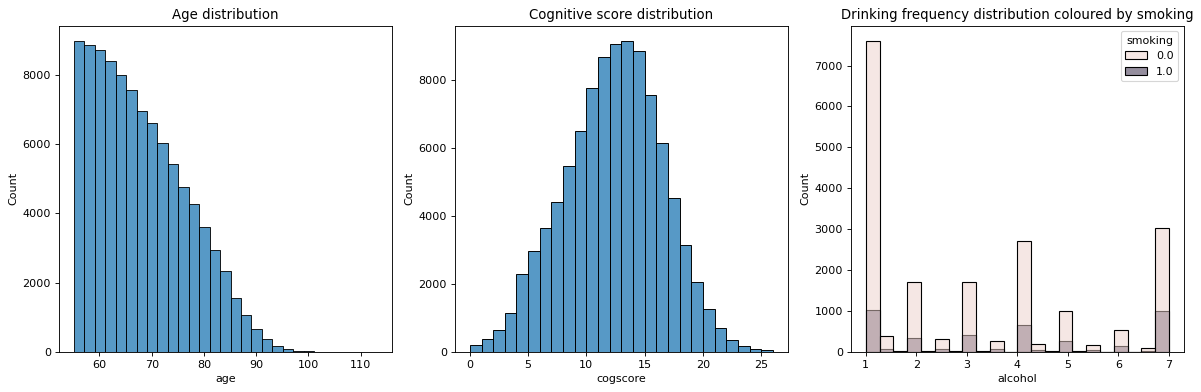

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey='none')

sns.histplot(ax = axes[0], data = d_cleaned, x = 'age', binwidth = 2)
axes[0].set_title('Age distribution')
sns.histplot(ax = axes[1], data = d_cleaned, x = 'cogscore', binwidth = 1)
axes[1].set_title('Cognitive score distribution')
sns.histplot(ax = axes[2], data = d_cleaned, x = 'alcohol', hue = 'smoking')
axes[2].set_title('Drinking frequency distribution coloured by smoking')
plt.tight_layout()

In [9]:
d_cleaned = d_cleaned.dropna(subset=['smoking', 'ever_smoked', 'br015_', 'chronic_mod'])

In [10]:
d_cleaned.isna().sum()

country_mod        0
age                0
isced1997_r        0
eurod           1484
bmi             2630
smoking            0
ever_smoked        0
br010_mod      17645
br015_             0
casp           13239
chronic_mod        0
sp008_         14172
cogscore           0
alcohol        72865
dtype: int64

In [11]:
features = list(d_cleaned.columns)

In [12]:
#imputing missing data:

num_imputer = SimpleImputer(strategy="median")

num_cols_imputer = ColumnTransformer(
    # apply the `num_imputer` to all columns apart from the last
    [("num", num_imputer, list(range(d_cleaned.shape[1] - 1)))],
    # don't touch all other columns, instead concatenate it on the end of the
    # changed data.
    remainder = "passthrough"
)

dimp = num_imputer.fit_transform(d_cleaned)

In [13]:
df = pd.DataFrame(dimp, columns=features)

# Training and Testing

In [14]:
rng = np.random.seed(0)
train_set, test_set = train_test_split(df, train_size = 0.8, random_state = rng)

X_train = train_set.drop(['cogscore'], axis=1)
y_train = train_set.cogscore

X_test = test_set.drop(['cogscore'], axis=1)
y_test = test_set.cogscore

In [15]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [16]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return Metrics

In [17]:
numeric_variables = ['bmi', 'eurod', 'isced1997_r', 'br015_', 'casp', 'chronic_mod', 'alcohol', 'age', 'br010_mod']

# Baseline Model

In [18]:
# Define the transformers
ohcenc = OneHotEncoder(handle_unknown='ignore')
num_transformer = Pipeline([("num_scale", StandardScaler())])

#defining the pipeline for one-hot-encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_nonord', ohcenc, ['country_mod'])
    ],
    remainder='passthrough'  # If there are other columns not specified, they will be passed through
)

#defining the pipeline to include standard scaling as well as o-h-e
preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat_nonord', ohcenc, ['country_mod']),
        ('num_scale', num_transformer, numeric_variables)
    ],
    remainder='passthrough'  # If there are other columns not specified, they will be passed through
)

In [19]:
#baseline model is linear regression with one-hot-encoding applied to the country variable

basemod = make_pipeline(
    preprocessor,
    LinearRegression()
).fit(X_train, y_train)

In [22]:
coefs = get_coefs(basemod.named_steps['linearregression'])
feature_names = basemod.named_steps['columntransformer'].get_feature_names_out()
#print(np.c_[np.append(['intercept'],feature_names),np.round(coefs,4)])

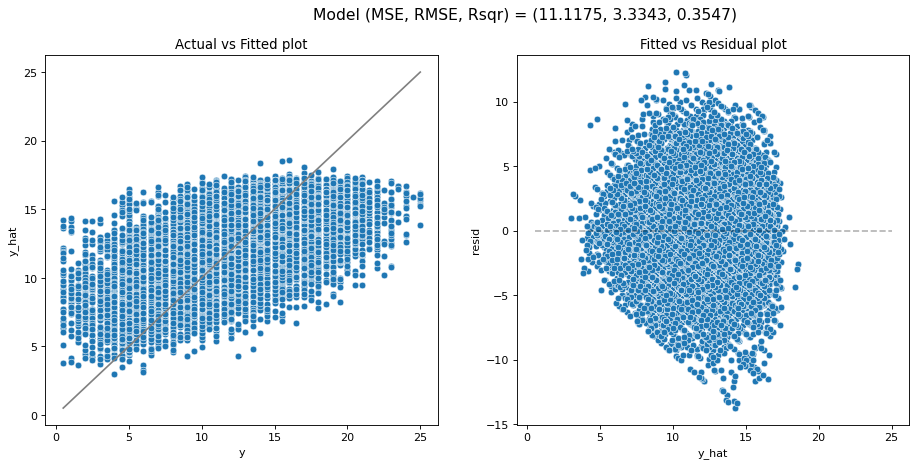

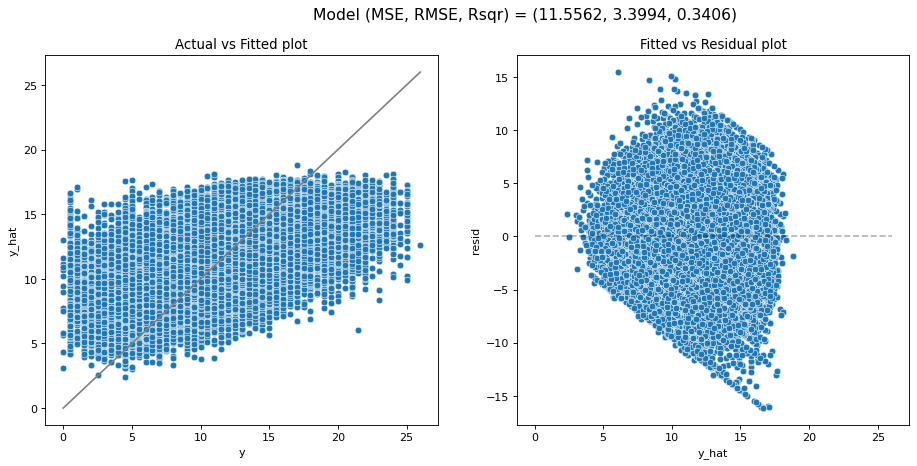

(11.5562, 3.3994, 0.3406)

In [23]:
model_fit(basemod, X_test, y_test, plot = True)
model_fit(basemod, X_train, y_train, plot = True)

In [27]:
#to avoid the curse of dimensionality, we select KBest features at this stage

KBest = SelectKBest(f_regression, k = 16)

KBestmod = make_pipeline(
    preprocessor,
    KBest,
).fit(X_train, y_train)

ind = KBestmod.named_steps['selectKbest'].get_support(indices = True)

KeyError: 'selectKbest'